In [1]:
#| default_exp activations

## Activation stats

### A simple Baseline

In [2]:
#|export
from __future__ import  annotations
import random,math,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from pathlib import Path
from operator import attrgetter, itemgetter
from functools import partial

from torch import tensor,nn,optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset

from miniai.datasets import *
from miniai.learner import  *

In [4]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

import logging
logging.disable(logging.WARNING)

In [13]:
#|export
def set_seed(seed):
    torch.use_deterministic_algorithms(True)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [14]:
x,y = 'image','label'
name = 'fashion_mnist'
dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train

### Baseline

In [15]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def cnn_layers():
    return [
        conv(1, 8, ks=5),
        conv(8, 16),
        conv(16, 32),
        conv(32, 64),
        conv(64, 10, act=False),
        nn.Flatten()
    ]

We want to train quickly, so that means training at a high learning rate

In [16]:
from torcheval.metrics import MulticlassAccuracy

In [17]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

In [21]:
def fit(model, epochs=1):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs)
    learn.fit(epochs)
    return learn

accuracy,loss,epoch,train
0.155,2.297,0,train
0.285,2.061,0,eval


/home/chung/miniconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1708025842427/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


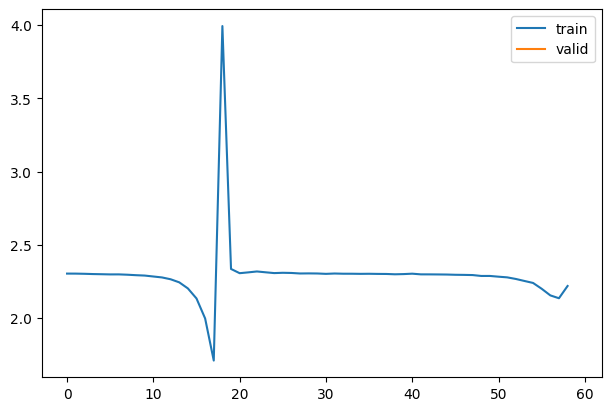

In [22]:
set_seed(1)
learn = fit(nn.Sequential(*cnn_layers()))

## Hooks

In [23]:
### Manual Insertion

In [27]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]

    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(to_cpu(x).mean())
            self.act_stds[i].append(to_cpu(x).std())
        return x

    def __iter__(self): return iter(self.layers) 

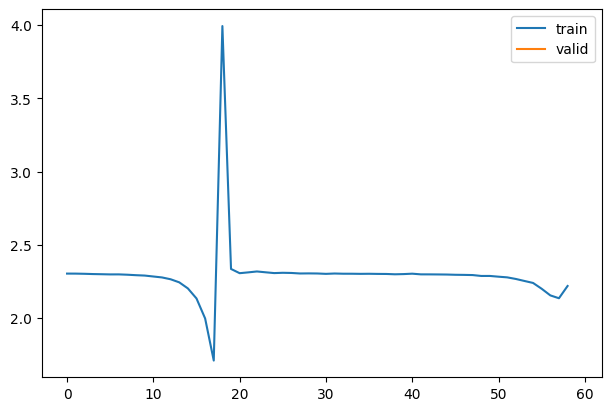

In [28]:
set_seed(1)
model = SequentialModel(*cnn_layers())
learn = fit(model)

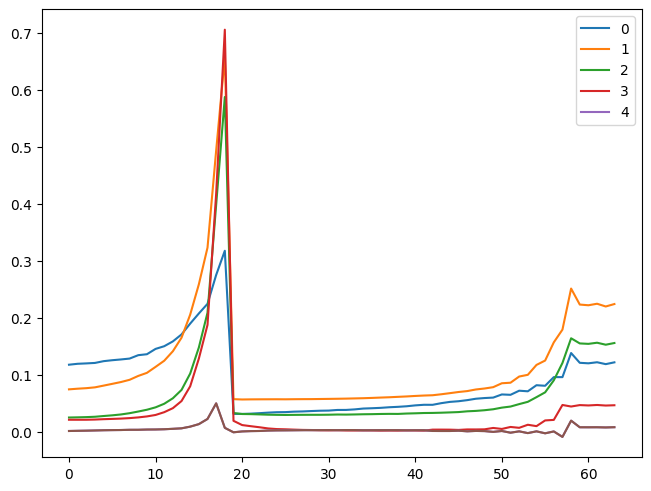

In [29]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5));

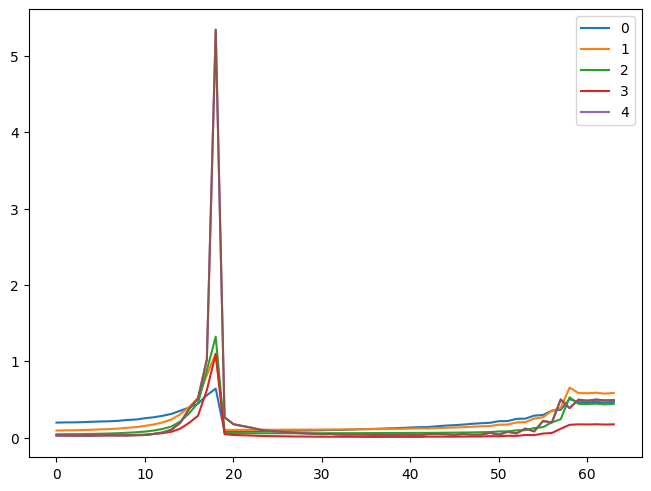

In [30]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5));

### Pytorch hooks
Hooks are PyTorch object you can add to any nn.Module. A hook will be called when a layer, it is registered to, is executed during the forward pass (forward hook) or backward pass (backward hook). Hooks don't require us to rewrite model.

In [48]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

A hook is attached to a layer, and needs to have function that takes three arguments: module, input, ouput.  Here we store the mean and std of the output in the correct position of our list.

In [49]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

In [50]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(to_cpu(outp).mean())
    act_stds[i].append(to_cpu(outp).std())

In [51]:
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

accuracy,loss,epoch,train
0.155,2.297,0,train
0.285,2.061,0,eval


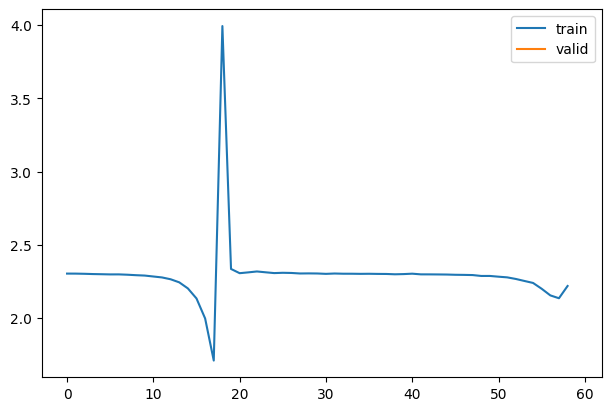

In [52]:
fit(model)

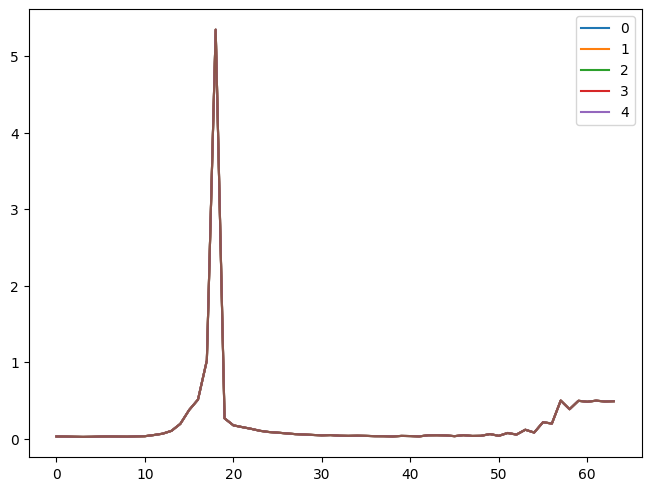

In [53]:
for o in act_means: plt.plot(l)
plt.legend(range(5));

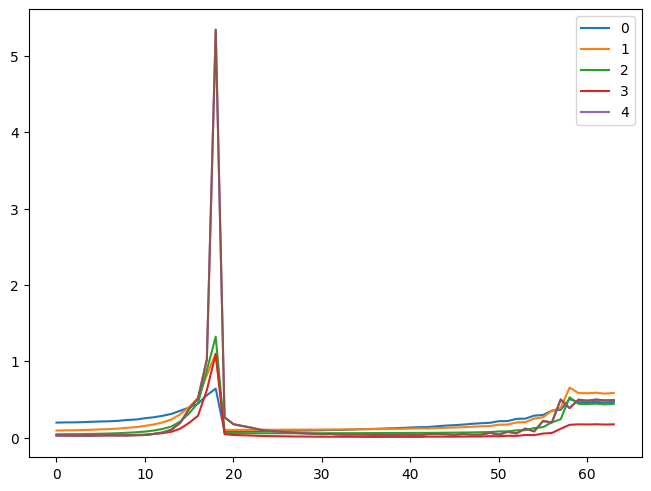

In [54]:
for o in act_stds: plt.plot(o)
plt.legend(range(5));

### Hook class
We can refactor this in a Hook class. It's very important to remove hooks when they are deleted, otherwise ther will be reference kept and the memory won't be propertly released when your model is deleted.

In [55]:
#| export 
class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())

In [56]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

In [57]:
hooks = [Hook(l, append_stats) for l in model[:5].children()]

accuracy,loss,epoch,train
0.155,2.297,0,train
0.285,2.061,0,eval


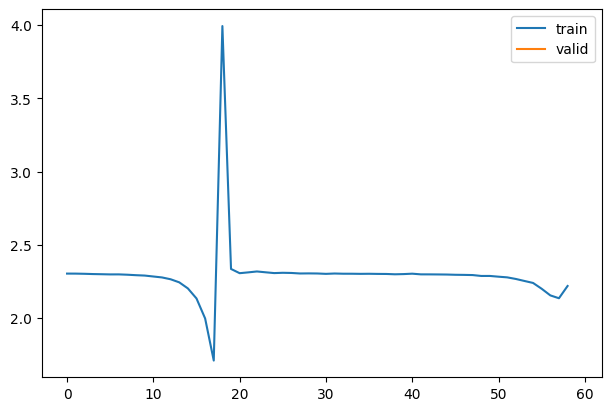

In [58]:
learn = fit(model)

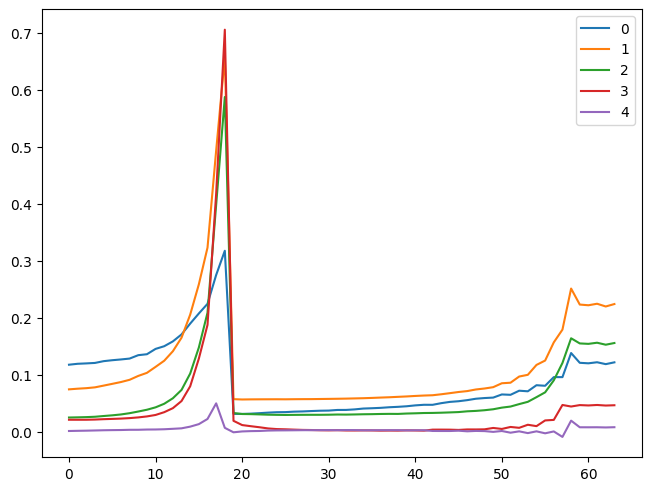

In [59]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(5));

### A Hooks class

In [68]:
class DummyCtxMgr:
    def __enter__(self, *args):
        print("let's go!")
        return self
    def __exit__(self, *args): print("all done!")
    def hello(self): print("hello.")

In [69]:
with DummyCtxMgr() as dcm: dcm.hello()

let's go!
hello.
all done!


In [70]:
class DummyList(list):
    def __delitem__(self, i):
        print(f"Say bye to item {i}")
        super().__delitem__(i)

In [74]:
dml = DummyList([1,3,2])
dml

[1, 3, 2]

In [75]:
del(dml[2])
dml

Say bye to item 2


[1, 3]

In [76]:
#| export
class Hooks(list):
    def __init__(self, ms, f): super().__init__([Hook(m,f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()
    def __del__(self): self.remove()
    def __delitem__(self,i):
        self[i].remove()
        super().__delitem__(i)
    def remove(self):
        for h in self: h.remove()

In [66]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

accuracy,loss,epoch,train
0.155,2.297,0,train
0.285,2.061,0,eval


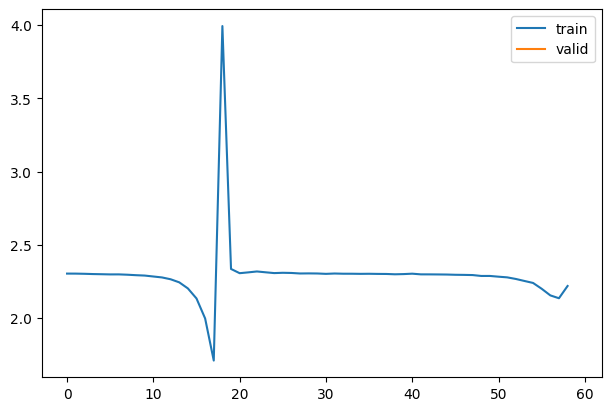

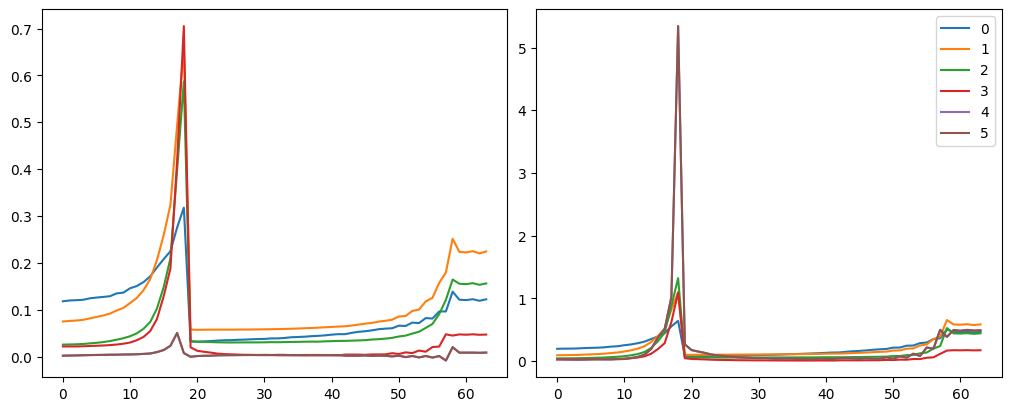

In [67]:
with Hooks(model, append_stats) as hooks:
    fit(model)
    fig, axs = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        for i in 0,1: axs[i].plot(h.stats[i])
    plt.legend(range(6));

In [77]:
#| export
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([],[],[])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(40, 0, 10))

In [78]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

accuracy,loss,epoch,train
0.155,2.297,0,train
0.285,2.061,0,eval


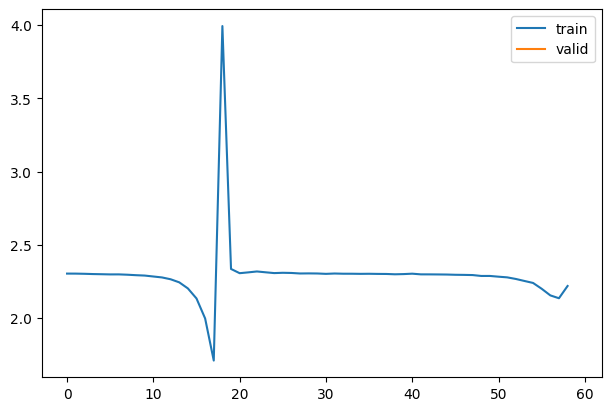

In [79]:
with Hooks(model, append_stats) as hooks: fit(model)

In [80]:
#| export
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

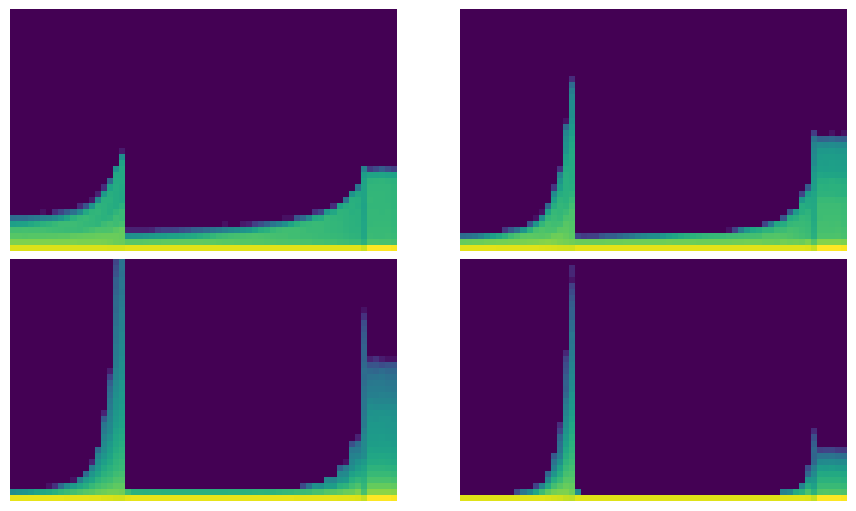

In [81]:
fit,axes = subplots(2,2, figsize=(9,5))
for ax,h in zip(axes.flatten(), hooks[:4]):
    show_image(get_hist(h), ax, origin='lower')

In [83]:
#| export 
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0)/h1.sum(0)

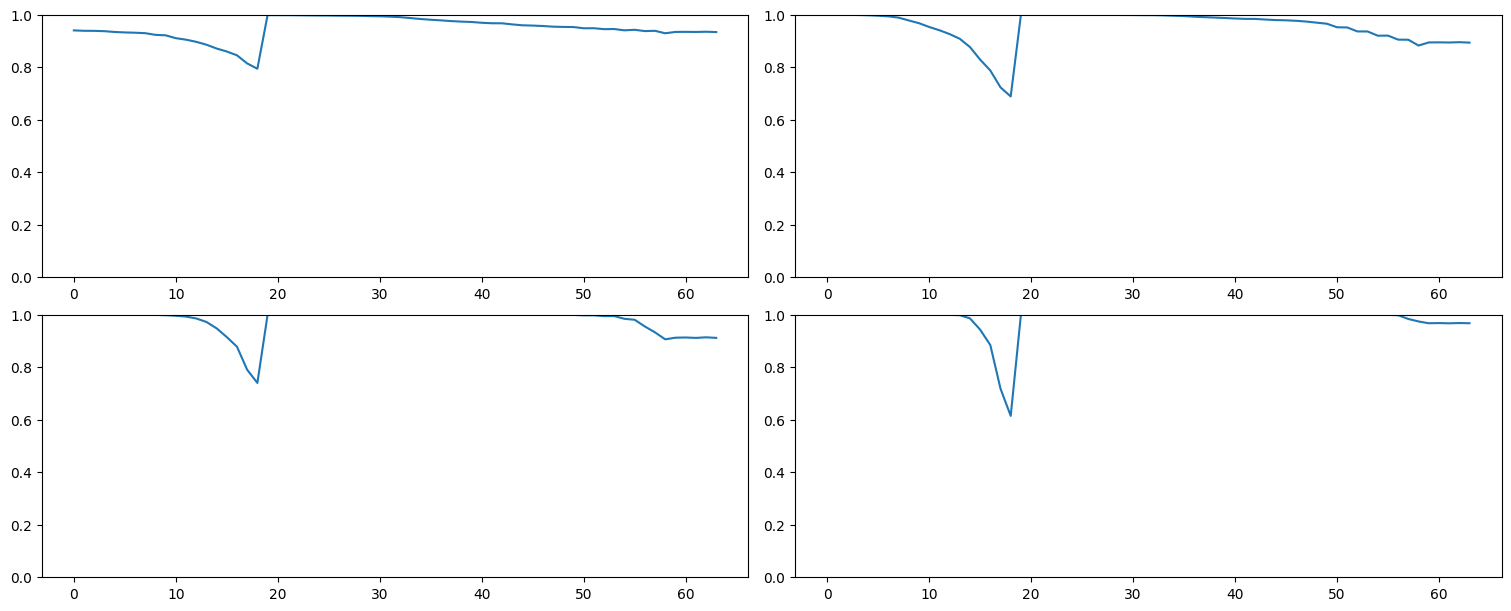

In [84]:
fixg,axes = subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)